**IMFDB Face Database**

Citation - 
Shankar Setty, Moula Husain, Parisa Beham, Jyothi Gudavalli, Menaka Kandasamy, Radhesyam Vaddi, Vidyagouri Hemadri, J C Karure, Raja Raju, Rajan, Vijay Kumar and C V Jawahar. "Indian Movie Face Database: A Benchmark for Face Recognition Under Wide Variations"
National Conference on Computer Vision, Pattern Recognition, Image Processing and Graphics (NCVPRIPG), 2013.

In [5]:
import numpy as np
import pandas as pd
import argparse
import errno
import scipy.misc
import cv2
from skimage.feature import hog
import os
from os import listdir
from os.path import isfile, join
from os import walk
import glob
import sys
import dlib
import pickle
import codecs
import PIL
from skimage import io
from skimage import color
%config IPCompleter.greedy=True
from PIL import Image
from skimage.transform import rescale, resize, downscale_local_mean
import matplotlib.pyplot as plt
import sys
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

**Data issues and preprocessing: **

The following files / folders had format issues (extra columns, missing data etc.), kindly delete these folders (AamairKhan/3Idiots, Aarthi/Bahaddurgandu, AkshayKumar/Barood, AnilKapoor/JamaiRaja, All BabuMohan, Balakrishna/odahuttidavaru, Bhanupriya/Annamayya, Bharathi/Extras, BomanIrani/3Idiots, BomanIrani/JolyLLB, Jagathi/Misc, Jagathi/Twenty-20, Jamuna/Gundammakatha, JayaBhaduri/Anamika, Kajol/KuchKuchhotahai, KatrinaKaif/ZindagiNaMilegiDobara,Madhavan/Cheli, Madhavan/3Idiots, Mallikarjunrao/HelloBrother, Mamootty/Twenty-20, Nagarjuna/HelloBrother, Nagarjuna/Nuvvu_Vasthavani,  NedumudiVenu/Dhwani, Pavithralokesh/extras_Malla, Pavithralokesh/extras_Raakshasudu/, PremaNazir/Dhwani, Ramaprabha/KalisundamRaa, Ramaprabha/Pandaga, Ramaprabha/Preminchukundamraa, Ranimukherji/KuchKuchhotahai, Rimisen/Misc, SalmanKhan/KuchKuchhotahai, Savithri/Gundammakatha, Savithri/Missamma, Shobana/Dhwani, Simran/Nuvvu_Vasthavani, Simran/KalisundamRaa, SoumithraChatterjee/charulatha, Soundarya/JayamManadera, All Srihari, Suryakantham/Gundammakatha, SVR/Mayabaazar, SVR/Gundammakatha,  Tenniskrishna/Extras, TanikellaBharani/JayamManadera, TanikellaBharani/Nuvvu_Vasthavani, TanikellaBharani/NarasimhaNaidu, Thilakan/Dhwani, SalmanKhan/Dabang2, Soundarya/HelloBrother) folders before runnig code.

Some of the files that have missing data / format issues are listed below -

IMFDB_final_Sample/AnilKapoor/JamaiRaja/AnilKapoor.txt

IMFDB_final_Sample/AkshayKumar/Barood/Barood.txt

IMFDB_final_Sample/AamairKhan/3Idiots/3Idiots.txt

All - IMFDB_final_Sample/BabuMohan

IMFDB_final_Sample/Balakrishna/odahuttidavaru

IMFDB_final_Sample/BomanIrani/3Idiots/3Idiots.txt

IMFDB_final/JayaBhaduri/Anamika/Anamika.txt

IMFDB_final/Jagathi/Misc/Misc.txt

IMFDB_final/Madhavan/Cheli/Cheli.txt

IMFDB_final/Mamootty/Twenty-20/Mammootty.txt

IMFDB_final/Rimisen/Misc/Misc.txt

IMFDB_final/SalmanKhan/Dabang2/Dabang2.txt

IMFDB_final/Soundarya/HelloBrother/Soundarya.txt

<b> Read all the text files and images files - </b>

In [6]:
Facial_Data=[]
director=[]
filepaths=[]
Id=[]
directory='IMFDB_final_Sample'
n=0
for root, dirs, files in os.walk(directory):
    for dir in dirs:
        director.append('IMFDB_final_Sample/' + dir)

for i in range(len(director)):
    for root2, dirs2, files2 in os.walk(director[i]):
        filedirec=map(lambda x : '/'.join([root2,x]),files2)
        filedirec = [f.replace('\\', '/') for f in filedirec]
        filepaths += filedirec         
        Id += [1*n]*len(filedirec)
        n=n+1
txt_filepaths = list(filter(lambda x:x.endswith((".txt")), filepaths))
image_filepaths = list(filter(lambda x:x.endswith((".jpg",".jpeg")), filepaths))

#colNames = ('Movie_Name','FileID','Image_Name','Col1',
#            'Col2','Col3','Col4','Title','Year_release','ActorName','Gender','FaceExpression',
#           'Occlusion', 'Illumination','Age','Pose', 'Makeup')
list_of_dfs=[]
for filepath in txt_filepaths:
  try:
    df=pd.read_csv(filepath, sep='\t',header=None)
    if((len(df.columns)==18) or (len(df.columns)==17)):
        df.drop(df.columns[0], axis=1)
        df = df.iloc[:,[2,7,10,11,15]]
        list_of_dfs.append(df)
        #print(filepath)
  except:
        print(filepath)
all_data = pd.concat(list_of_dfs, ignore_index=True)
all_data.columns = ('Image_Name','MovieName','Gender','FaceExpression','Pose')
all_data.head()

,Image_Name,MovieName,Gender,FaceExpression,Pose
0,AamirKhan_1.jpg,Andaz_Apna_Apna,MALE,NEUTRAL,RIGHT
1,AamirKhan_10.jpg,Andaz_Apna_Apna,MALE,NEUTRAL,FRONTAL
2,AamirKhan_100.jpg,Andaz_Apna_Apna,MALE,NEUTRAL,RIGHT
3,AamirKhan_101.jpg,Andaz_Apna_Apna,MALE,NEUTRAL,RIGHT
4,AamirKhan_102.jpg,Andaz_Apna_Apna,MALE,NEUTRAL,RIGHT


In [7]:
#all_data['MovieName'] = all_data['MovieName'].map(lambda x: x.lstrip('_'))
all_data.MovieName = all_data.MovieName.apply(lambda x: x.replace("_",""))
all_data.to_csv('all_data.txt', header=None, index=None, sep=',', mode='a')
all_data.head()

,Image_Name,MovieName,Gender,FaceExpression,Pose
0,AamirKhan_1.jpg,AndazApnaApna,MALE,NEUTRAL,RIGHT
1,AamirKhan_10.jpg,AndazApnaApna,MALE,NEUTRAL,FRONTAL
2,AamirKhan_100.jpg,AndazApnaApna,MALE,NEUTRAL,RIGHT
3,AamirKhan_101.jpg,AndazApnaApna,MALE,NEUTRAL,RIGHT
4,AamirKhan_102.jpg,AndazApnaApna,MALE,NEUTRAL,RIGHT


Export image data and file paths data to files which will be uploaded to Google Drive - 

In [8]:
Face_Data=[]
Face_FilePaths=[]
#detector = dlib.get_frontal_face_detector()
for pic in image_filepaths:
    img = image.load_img(pic, color_mode = "grayscale", target_size=(100, 100))
    try:
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis = 0)
        x /= 255
        Face_Data.append(x)
        Face_FilePaths.append(pic)
    except Exception as e:
        print(pic)
        print(str(e))
with open('face_site.data', 'wb') as filehandle:  
    # store the data as binary data stream
    pickle.dump(Face_Data, filehandle)

FilePaths_array=np.array(Face_FilePaths, 'str')
np.savetxt('FilePaths.txt', FilePaths_array, delimiter=" ", fmt="%s") 

Plot some images to see resolutions - 

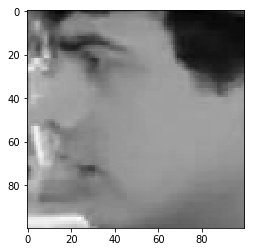

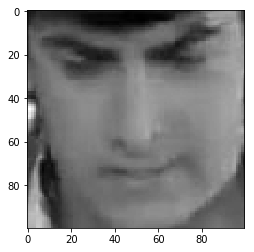

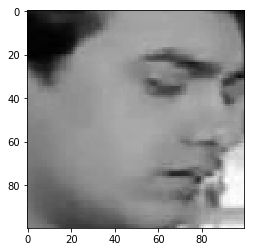

In [9]:
for i in range(3):
    x = np.array(Face_Data[i], 'float32')
    x = x.reshape([100, 100]);

    plt.gray()
    plt.imshow(x)
    plt.show() 